# Industrial Applications of Artificial Intelligence - Predictive Maintenance

### This notebook is part of the second hand-in regarding the secondary sector in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

Industrial companies rely heavily on the machines that operate within their assembly lines. Even the slighest error that would cause the line to be stopped will result in losses of serveral hundred to thousands of euros. In 2015, insiders calculated that one minute of downtime costs Daimler, BMW and AUDI between €1000 and €6000 [(src)](https://www.dvz.de/rubriken/logistik/it-in-der-logistik/detail/news/geruestet-fuer-den-blackout.html#:~:text=Denn%20eine%20Minute%20Bandstillstand%20bei,zwischen%201000%20und%206000%20EUR.). Due to rising competition in a global economy, predictive maintenance becomes a crucial task to no lose money and time in operations, because a company is able to prevent breakdowns with early countermeasures. The challenge arises for the company to prevent components from being replaced too early in the lifecycle and still ensuring reliability. Machine Learning can help in this task. By making use of data from the machines itself and sensors in the surrounding, companies are able to plan ahead and schedule actions to keep their assembly line healthy. One possible way to do this, is modelling the failure/non-failure of a machine as a binary classification. In the following we want to explore how to preprocess a related dataset and how models are able to support companies in recognizing a failure or not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## I. Import Data

The dataset can be found on kaggle unter the following [URL](https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification?select=predictive_maintenance.csv). As real data is in most of the cases a secret that is hidden by the respective company to not give an edge to competitors, we make use of a synthetically generated dataset found on kaggle that reflects real predictive maintenance encountered in industry. The dataset was  [published](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset ) by the Center for Machine Learning and Intelligent Systems of the University of California . First of all, the dataset consists out of 10.000 entries containing eight features and two targets, which will be described in the following.
* UDI: unique identifier having the same value as the corresponding index
* Product ID: Combination of a letter and a 4-digit serial number. The value of the letter reflects the quality of the product, where L stands for low, M for medium and H for high.
* Type: Again reflects the quality of the product in the same manner as the product ID.
* Air temperature [K]: Refleccts the temperature of the surrounding air measured in Kalvin (0°C = 173,15 K).
* Process temperature [K]: Measures the temperature within the process/machine in Kalvin.
* Rotational speed [rpm]: Corresponds to the rotation speed of the machine measured revolutions per minute .
* Torque [Nm]: Moment of force, rotational force in Newtonmeter. Rotational equivalent to linear force.
* Tool wear [min]: Gradual failure of tools due to regular operation. Depending on quality the add different minutes to the used tool (H/M/L -> 5/3/2 minutes). So, the value is reseted to zero, if the machine has been changed.
* Target: Binary: 1: Failure/0: Non-Failure 
* Failure Type

In [343]:
dir_path ='../../src/data/Abgabe_2/'
df = pd.read_csv(os.path.join(dir_path, "predictive_maintenance.csv"))
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


During the training, we noticed that some algorithms, in particular XGBoost, cannot cope with specific values in the feature names of our dataframe (in our case "[ ]". So, we will clean this up in the beginning for the whole table.

In [344]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
df.head(10)

,UDI,Product ID,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


As we already know that UDI is always the same value as the index+1, we discard the column.

In [345]:
df = df.drop(columns=['UDI'])
# look at distribution
df.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,10000.00,300.00,2.00,295.30,298.30,300.10,301.50,304.50
Process temperature K,10000.00,310.01,1.48,305.70,308.80,310.10,311.10,313.80
Rotational speed rpm,10000.00,1538.78,179.28,1168.00,1423.00,1503.00,1612.00,2886.00
Torque Nm,10000.00,39.99,9.97,3.80,33.20,40.10,46.80,76.60
Tool wear min,10000.00,107.95,63.65,0.00,53.00,108.00,162.00,253.00
Target,10000.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00


In [346]:
df.isna().sum()

Product ID               0
Type                     0
Air temperature K        0
Process temperature K    0
Rotational speed rpm     0
Torque Nm                0
Tool wear min            0
Target                   0
Failure Type             0
dtype: int64

Since we have a synthetical dataset, we do not have any NA values. So, we do not need to further preprocess the data in that regard. In the following, we will also discard the failure type, as we want to focus on the binary classification of failure/non-failure. Including the failure type column as a feature to the algorithm would be a false predictor, as it would spoil the label since no-failure does always correspond to 0 in the target.

In [347]:
df = df.drop(columns=['Failure Type'])

After dropping the column, we will again look at our data to decide whether we have to scale it or not.

In [348]:
# look at distribution
df.describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,10000.00,300.00,2.00,295.30,298.30,300.10,301.50,304.50
Process temperature K,10000.00,310.01,1.48,305.70,308.80,310.10,311.10,313.80
Rotational speed rpm,10000.00,1538.78,179.28,1168.00,1423.00,1503.00,1612.00,2886.00
Torque Nm,10000.00,39.99,9.97,3.80,33.20,40.10,46.80,76.60
Tool wear min,10000.00,107.95,63.65,0.00,53.00,108.00,162.00,253.00
Target,10000.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00


We see that our scales for the different features, differ a lot. That could possibly have a big impact on the algorithms' performances. However, we do not want to do that on all the data, but rather fit the scaler on the train data only and use it on test and validation. So, we will come back to that after the train test split.

On top of that, we currently have currently have two categorical features. For the algorithms to be able to work with them in the downstream tasks, we will one-hot encode them. However, before we do that, we will get rid of the letter in the product ID, as we always have that in the type column already.

In [349]:
# we strip the letters from the numbers and use only the numbers for the Product ID
df['Product ID'] = df['Product ID'].apply(lambda row: int(''.join(filter(str.isdigit, row))))

In [350]:
df.head(10)

,Product ID,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target
0,14860,M,298.1,308.6,1551,42.8,0,0
1,47181,L,298.2,308.7,1408,46.3,3,0
2,47182,L,298.1,308.5,1498,49.4,5,0
3,47183,L,298.2,308.6,1433,39.5,7,0
4,47184,L,298.2,308.7,1408,40.0,9,0
5,14865,M,298.1,308.6,1425,41.9,11,0
6,47186,L,298.1,308.6,1558,42.4,14,0
7,47187,L,298.1,308.6,1527,40.2,16,0
8,14868,M,298.3,308.7,1667,28.6,18,0
9,14869,M,298.5,309.0,1741,28.0,21,0


In [351]:
# we still see that we have no duplicate numbers
df['Product ID'].nunique()

10000

We can still see that we do not have any duplicates in our column. So, the ID does not offer any further information in our downstream tasks. So, we discard this column as it has a 1:1 relationship to our index.

In [352]:
df = df.drop(columns=['Product ID'])

In [12]:
# encode type as last remaining categorical feature
categorical_features = ['Type']
encoder = OneHotEncoder()
#create encoded dataframe
encoded = pd.DataFrame(encoder.fit_transform(df[categorical_features]).toarray(), columns=encoder.get_feature_names(categorical_features))
df_ohe = df.drop(columns=categorical_features).join(encoded)
df_ohe.head(10)

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0.0,0.0,1.0
1,298.2,308.7,1408,46.3,3,0,0.0,1.0,0.0
2,298.1,308.5,1498,49.4,5,0,0.0,1.0,0.0
3,298.2,308.6,1433,39.5,7,0,0.0,1.0,0.0
4,298.2,308.7,1408,40.0,9,0,0.0,1.0,0.0
5,298.1,308.6,1425,41.9,11,0,0.0,0.0,1.0
6,298.1,308.6,1558,42.4,14,0,0.0,1.0,0.0
7,298.1,308.6,1527,40.2,16,0,0.0,1.0,0.0
8,298.3,308.7,1667,28.6,18,0,0.0,0.0,1.0
9,298.5,309.0,1741,28.0,21,0,0.0,0.0,1.0


In a last preprocessing step, we will deeper investigate that in the following and drop a feature if it has a correlation of more than 0.8 to one of the other features (excluding the target).

In [13]:
def drop_correlated_features(df:pd.DataFrame, thr:float) -> pd.DataFrame:
    """
    Function to detect all correlated features
    :param df: general dataframe
    :param thr: threshold for the correlation param
    :return: dataframe without correlated features
    """
    correlated_features = set()
    correlation_matrix = df.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > thr:
                print(
                    f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]), 2)}")
                colname = correlation_matrix.columns[j]
                correlated_features.add(colname)
    print(f"Drop the following features: {correlated_features}")
    # drop correlated features
    df = df.drop(columns=correlated_features)

    return df

C:\Users\Nikla\AppData\Local\Temp\ipykernel_20624\3025600473.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


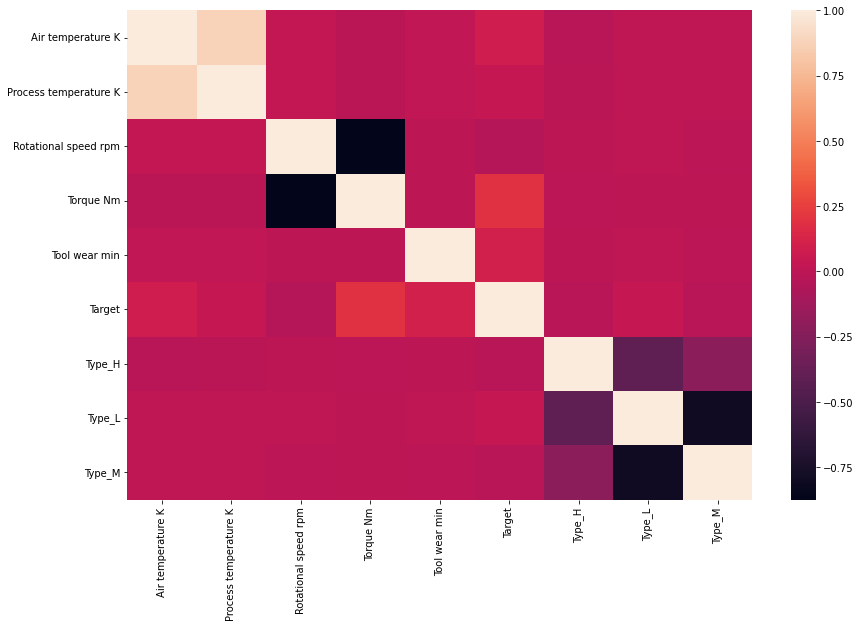

In [14]:
# investigate correlation heatmap
corrMatrix=df_ohe.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [15]:
#drop target to not use it in the correlations of the explanatory variables
df_target = df_ohe['Target']
df_cor = df_ohe.drop(columns=['Target'])
# drop highly correlated features
df_cor = drop_correlated_features(df_cor, 0.8)

The following features are correlated: Process temperature K and Air temperature K. Correlation = 0.88
The following features are correlated: Torque Nm and Rotational speed rpm. Correlation = 0.88
The following features are correlated: Type_M and Type_L. Correlation = 0.8
Drop the following features: {'Air temperature K', 'Type_L', 'Rotational speed rpm'}


In a last step, we will again concatenate the target column to our dataframe.

In [16]:
df_preprocessed = pd.concat([df_cor, df_target], axis=1)
df_preprocessed.head(5)

,Process temperature K,Torque Nm,Tool wear min,Type_H,Type_M,Target
0,308.6,42.8,0,0.0,1.0,0
1,308.7,46.3,3,0.0,0.0,0
2,308.5,49.4,5,0.0,0.0,0
3,308.6,39.5,7,0.0,0.0,0
4,308.7,40.0,9,0.0,0.0,0


We will now aggregate all our preprocessing steps in one function, that can be varied depending on settings we want to test. Such that we can easily adjust the parameters based on the setting, we want to test (e.g., keep correlated features vs. drop them).

We are now done with preprocessing and will create a train-test split in the following that can be used in downstream tasks.

# II. Train-Test-Split

Since we do not have a given split up into train, test and validation, we will create that in the following. We will therefore split our given data into 60% train, 20% val and 20% test. Before we do that, we will have a short look on the distribution of our target to check for an imbalanced set.

In [17]:
df_preprocessed = df_ohe

<AxesSubplot:>

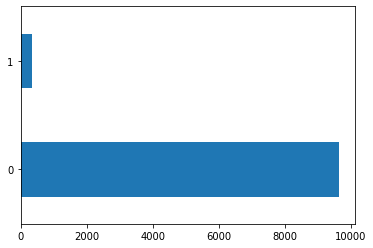

In [18]:
df_preprocessed['Target'].value_counts().plot(kind ='barh')

In [19]:
df_preprocessed['Target'].value_counts()

0    9661
1     339
Name: Target, dtype: int64

We can clearly see that we have an highly unbalanced dataset and therefore need to make sure to include all classes in our splitted sets via stratified sampling. The imbalance is also an indicator to use the f1-score as metric for our further downstream task instead of the accuracy, as accuracy would deliver a good result for not predicting the minor class at all.

In [20]:
# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_preprocessed.drop(columns=['Target']), df_preprocessed['Target'], test_size=0.2, random_state=42, stratify=df_preprocessed['Target'])

In [21]:
#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

We will now have a look at the values in our different sets to check wether the distribution of the target is nearly the same.

In [22]:
# define values for plots
x = ['0','1']
y_train = target_train.value_counts().to_list()
y_val = target_val.value_counts().to_list()
y_test = target_test.value_counts().to_list()

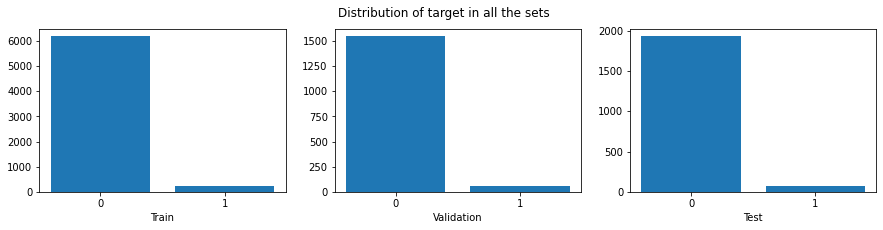

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(15,3))
fig.suptitle('Distribution of target in all the sets')
ax1.bar(x, y_train)
ax1.set_xlabel('Train')
ax2.bar(x, y_val)
ax2.set_xlabel('Validation')
ax3.bar(x, y_test)
ax3.set_xlabel('Test')
plt.show()

We can clearly see that the distribution is nearly the same for all our sets. As we generated the train-test-validation split in the previous step, we now want to scale the data as described earlier. This is for the reason, that different scales might actually distort our algorithm a lot due to big differences in the scales. For scaling we use the StandardScaler from the sklearn package. It should be noted that we only fit the scaler on our training data and use only the transformation on the validation and testing part, because we want to keep them completely separated.

In [24]:
# define standard scaler
scaler = StandardScaler()
# features to scale
numerical_features = ['Process temperature K','Torque Nm','Tool wear min', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In [25]:
data_train.head(5)

,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Type_H,Type_L,Type_M
8204,-0.303801,0.605754,1.182947,-1.218791,-1.524967,0.0,1.0,0.0
8372,-0.604270,-0.206288,-0.508422,0.480406,-1.195608,0.0,0.0,1.0
292,-0.954816,-1.086000,-1.139196,0.020623,0.027726,0.0,1.0,0.0
4460,1.298695,0.335073,0.317726,-0.719027,1.345163,0.0,1.0,0.0
6499,0.447369,-0.003278,0.736381,-1.318744,1.439265,0.0,1.0,0.0


In [26]:
data_val.head(5)

,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Type_H,Type_L,Type_M
1267,-0.954816,-0.273958,0.055368,-0.129306,-1.007403,0.0,0.0,1.0
5085,1.999787,2.026827,-0.904749,1.599876,-0.725095,0.0,0.0,1.0
440,-1.305362,-1.018330,-0.837764,-0.079330,-0.834881,0.0,1.0,0.0
3445,0.797915,0.402743,0.334472,-0.389183,1.580419,0.0,0.0,1.0
1693,-1.004894,-1.695032,0.803366,-1.218791,-1.274027,1.0,0.0,0.0


In [27]:
data_test.head(5)

,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Type_H,Type_L,Type_M
2997,0.247057,-0.138618,-1.083375,2.269560,0.717812,0.0,1.0,0.0
4871,1.849553,1.620806,-0.145587,0.010628,0.435504,0.0,1.0,0.0
3858,1.248617,0.944104,0.111189,-0.239254,1.596103,0.0,1.0,0.0
951,-2.206766,-2.507073,-0.167915,-0.419169,-0.740779,1.0,0.0,0.0
6463,0.247057,-0.003278,-1.010808,2.039668,-0.082060,1.0,0.0,0.0


Since we have scaled the data, we can now continue with our baseline.

# III. Baseline

Our baseline will be an easy prediction using only the majority class for our validation set. Therefore all our values will be set to 0. Since we want to get the f1_score weighted over all classes, we use the macro averaged one to better understand the performance.

In [28]:
prediction = np.zeros(len(target_val))
acc = accuracy_score(target_val,prediction) 
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("The Accuracy on the validation set: {:.4f}".format(acc))
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

The Accuracy on the validation set: 0.9663
The F1-Score micro on the validation set: 0.4914
The Precision on the validation set: 0.4831
The Recall on the validation set: 0.5000
Confusion Matrix : 
[[1546    0]
 [  54    0]]


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can clearly see that our model is worse that guessing, as we are only predicting the major class. However, as already indicated, one could also see that we do have a pretty high accuracy, as our dataset is extremly imbalanced, as failures occur normally far less than no failures. That is the reason, why accuracy is not a good measure in our case and we will focus on the f1_score.

# IV. Modelling

In the following, we will first try out some models and see how they behave with their default values, afterwards we will focus on 1 or 2 models for extensive training to achieve better results.

### Logistic Regression

In [29]:
lr = LogisticRegression()
cross_val=cross_val_score(lr, data_train, target_train, cv=5, scoring='f1_macro')
lr.fit(data_train,target_train)
prediction = lr.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

CV-average F1-score: 0.6402
The F1-Score micro on the validation set: 0.6544
The Precision on the validation set: 0.8793
The Recall on the validation set: 0.6009
Confusion Matrix : 
[[1543    3]
 [  43   11]]


### SVM

In [30]:
svc = SVC()
cross_val=cross_val_score(svc, data_train, target_train, cv=5, scoring='f1_macro')
svc.fit(data_train,target_train)
prediction = svc.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

CV-average F1-score: 0.6623
The F1-Score micro on the validation set: 0.7158
The Precision on the validation set: 0.9324
The Recall on the validation set: 0.6475
Confusion Matrix : 
[[1544    2]
 [  38   16]]


### Naive Bayes

In [31]:
nb=GaussianNB()
cross_val=cross_val_score(nb, data_train, target_train, cv=5, scoring='f1_macro')
nb.fit(data_train,target_train)
prediction = nb.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

CV-average F1-score: 0.6316
The F1-Score micro on the validation set: 0.6602
The Precision on the validation set: 0.6878
The Recall on the validation set: 0.6404
Confusion Matrix : 
[[1522   24]
 [  38   16]]


### Random Forest

In [32]:
rf = RandomForestClassifier()
cross_val=cross_val_score(rf, data_train, target_train, cv=5,scoring='f1_macro')
rf.fit(data_train, target_train)
prediction = rf.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

CV-average F1-score: 0.8022
The F1-Score micro on the validation set: 0.8327
The Precision on the validation set: 0.9452
The Recall on the validation set: 0.7675
Confusion Matrix : 
[[1543    3]
 [  25   29]]


### XGBoost

In [33]:
xgb = XGBClassifier()
cross_val=cross_val_score(xgb, data_train, target_train, cv=5, scoring='f1_macro')
xgb.fit(data_train, target_train)
prediction = xgb.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

[16:56:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[16:56:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:56:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:56:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:56:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:56:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV-average F1-score: 0.8742
The F1-Score micro on the validation set: 0.8644
The Precision on the validation set: 0.9207
The Recall on the validation set: 0.8221
Confusion Matrix : 
[[1540    6]
 [  19   35]]


### MLP Classifier

In [34]:
mlp=MLPClassifier()
cross_val=cross_val_score(mlp, data_train, target_train, cv=5, scoring='f1_macro')
mlp.fit(data_train,target_train)
prediction = mlp.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_pe

CV-average F1-score: 0.8060
The F1-Score micro on the validation set: 0.8285
The Precision on the validation set: 0.9090
The Recall on the validation set: 0.7758
Confusion Matrix : 
[[1540    6]
 [  24   30]]


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


We have now fitted some models and see the scores with 5-fold cross-validation on our training data. We can clearly see, that all the models perform better than our baseline with random forest, xgboost and the multi-layer perceptron performing far better than the rest. That was to be expected, as those models are already more sophisticated due to ensemble methods and mlp more intensive as neural network than naive bayes, logistic regression and support vector classification.

However, as we can see the models make different mistakes. So, it can be useful to combine them in an ensemble strategy.

In [35]:
lr = LogisticRegression()
nb=GaussianNB()
svc = SVC()
rf = RandomForestClassifier()
xgb = XGBClassifier()
mlp=MLPClassifier()


vo_cl = VotingClassifier([ ('nb', nb),('svc',svc), ('rf',rf), ('xgb',xgb), ('mlp',mlp)])
vo_cl.fit(data_train, target_train)
prediction = vo_cl.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:57:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


CV-average F1-score: 0.8060
The F1-Score micro on the validation set: 0.7997
The Precision on the validation set: 0.9372
The Recall on the validation set: 0.7305
Confusion Matrix : 
[[1543    3]
 [  29   25]]


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


After using a lot of different settings, it seems like the voting ensemble gets mostly dominated by the best classifier from the earlier stage and there is no real improvement compared to that with our default values.

We will now test a setting where we keep the correlatedf features for our best models, in particular XGBoost, Random Forest and the MLP Classifier. Per default those models should be able to handle correlated data instead of some other algorithms. And as they are already far better than the other models, we will focus on them in the following.

# V. RF, XGBoost and MLP with correlated features

We will start our pipeline after the one-hot encoding step in cell 12 and leave the dropping of correlated features out.

In [36]:
df_ohe.head(10)

,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0.0,0.0,1.0
1,298.2,308.7,1408,46.3,3,0,0.0,1.0,0.0
2,298.1,308.5,1498,49.4,5,0,0.0,1.0,0.0
3,298.2,308.6,1433,39.5,7,0,0.0,1.0,0.0
4,298.2,308.7,1408,40.0,9,0,0.0,1.0,0.0
5,298.1,308.6,1425,41.9,11,0,0.0,0.0,1.0
6,298.1,308.6,1558,42.4,14,0,0.0,1.0,0.0
7,298.1,308.6,1527,40.2,16,0,0.0,1.0,0.0
8,298.3,308.7,1667,28.6,18,0,0.0,0.0,1.0
9,298.5,309.0,1741,28.0,21,0,0.0,0.0,1.0


In a first step, we split up the data again.

In [37]:
df_preprocessed = df_ohe

# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_preprocessed.drop(columns=['Target']), df_preprocessed['Target'], test_size=0.2, random_state=42, stratify=df_preprocessed['Target'])

#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

Since we haven't scaled the features yet, we will make use of the same scaler method again.

In [38]:
# define standard scaler
scaler = StandardScaler()
# features to scale
numerical_features = ['Process temperature K','Torque Nm','Tool wear min', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In the following, we will test the sets with our three best previous model and decide if we want to keep the features or not.

### Random Forest

In [42]:
rf = RandomForestClassifier()
cross_val=cross_val_score(rf, data_train, target_train, cv=5,scoring='f1_macro')
rf.fit(data_train, target_train)
prediction = rf.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

CV-average F1-score: 0.7970
The F1-Score micro on the validation set: 0.8327
The Precision on the validation set: 0.9452
The Recall on the validation set: 0.7675
Confusion Matrix : 
[[1543    3]
 [  25   29]]


### XGBoost

In [40]:
xgb = XGBClassifier()
cross_val=cross_val_score(xgb, data_train, target_train, cv=5, scoring='f1_macro')
xgb.fit(data_train, target_train)
prediction = xgb.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

[17:08:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[17:08:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:08:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV-average F1-score: 0.8742
The F1-Score micro on the validation set: 0.8644
The Precision on the validation set: 0.9207
The Recall on the validation set: 0.8221
Confusion Matrix : 
[[1540    6]
 [  19   35]]


### MLP Classifier

In [41]:
mlp=MLPClassifier()
cross_val=cross_val_score(mlp, data_train, target_train, cv=5, scoring='f1_macro')
mlp.fit(data_train,target_train)
prediction = mlp.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_pe

CV-average F1-score: 0.8195
The F1-Score micro on the validation set: 0.8364
The Precision on the validation set: 0.9335
The Recall on the validation set: 0.7765
Confusion Matrix : 
[[1542    4]
 [  24   30]]


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


If we have a look at the average cross-validation score, we can see that XGBoost has nearly the same values, Random Forest slightly worse and the MLP better scores. So, as expected XGBoost and the MLP-Classifier are able to handle the values and we will proceed without dropping the features and continue focusing on XGBoost and the multi-layer-perceptron.

# V. Feature Generation

We now want to have a look at the data itself to understand if we are able to achieve better performances by engineering further features.

In [133]:
df.head(10)

,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0
5,M,298.1,308.6,1425,41.9,11,0
6,L,298.1,308.6,1558,42.4,14,0
7,L,298.1,308.6,1527,40.2,16,0
8,M,298.3,308.7,1667,28.6,18,0
9,M,298.5,309.0,1741,28.0,21,0


In [134]:
# look at distribution
df[df.Target == 0].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,9661.00,299.97,1.99,295.30,298.30,300.00,301.50,304.50
Process temperature K,9661.00,310.00,1.49,305.70,308.80,310.00,311.10,313.80
Rotational speed rpm,9661.00,1540.26,167.39,1168.00,1429.00,1507.00,1615.00,2695.00
Torque Nm,9661.00,39.63,9.47,12.60,33.10,39.90,46.30,70.00
Tool wear min,9661.00,106.69,62.95,0.00,52.00,107.00,160.00,246.00
Target,9661.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [135]:
# look at distribution
df[df.Target == 1].describe().transpose().applymap("{:.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Air temperature K,339.00,300.89,2.07,295.60,299.10,301.60,302.50,304.40
Process temperature K,339.00,310.29,1.36,306.10,309.50,310.40,311.20,313.70
Rotational speed rpm,339.00,1496.49,384.94,1181.00,1326.50,1365.00,1421.50,2886.00
Torque Nm,339.00,50.17,16.37,3.80,45.95,53.70,61.20,76.60
Tool wear min,339.00,143.78,72.76,0.00,84.50,165.00,207.50,253.00
Target,339.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


Based on the distributions, we can see that the mean of tool wear and torque are a lot higher for failures than for non-failures. Our first assumption is that for high tool wear values a failure is more likely to happen, as the machine was used a lot and shows abrasion. On top of that if the tool is set under stress with force a crash is more likely to happen if the tool wear is already high. We have a further look into the distributions.

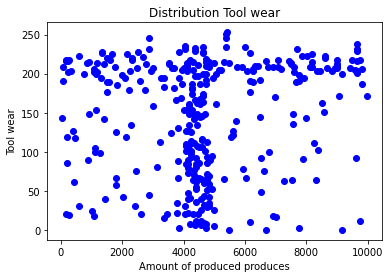

In [136]:
plt.scatter(df[df.Target == 1].index, df[df.Target == 1]['Tool wear min'], color='b')
plt.title('Distribution Tool wear')
plt.xlabel('Amount of produced produces')
plt.ylabel('Tool wear')
plt.show()

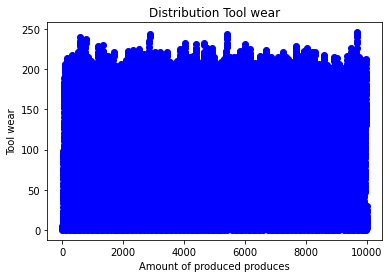

In [393]:
plt.scatter(df[df.Target == 0].index, df[df.Target == 0]['Tool wear min'], color='b')
plt.title('Distribution Tool wear')
plt.xlabel('Amount of produced produces')
plt.ylabel('Tool wear')
plt.show()

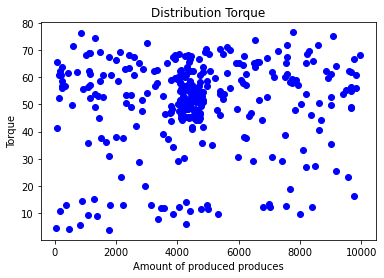

In [137]:
plt.scatter(df[df.Target == 1].index, df[df.Target == 1]['Torque Nm'], color='b')
plt.title('Distribution Torque')
plt.xlabel('Amount of produced produces')
plt.ylabel('Torque')
plt.show()

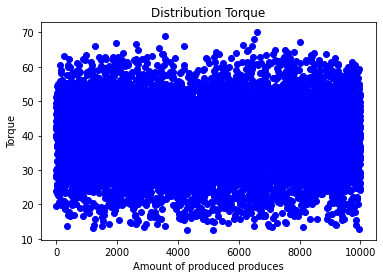

In [379]:
plt.scatter(df[df.Target == 0].index, df[df.Target == 0]['Torque Nm'], color='b')
plt.title('Distribution Torque')
plt.xlabel('Amount of produced produces')
plt.ylabel('Torque')
plt.show()

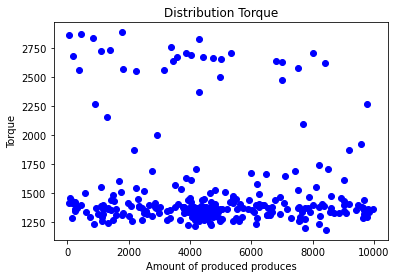

In [394]:
plt.scatter(df[df.Target == 1].index, df[df.Target == 1]['Rotational speed rpm'], color='b')
plt.title('Distribution Torque')
plt.xlabel('Amount of produced produces')
plt.ylabel('Torque')
plt.show()

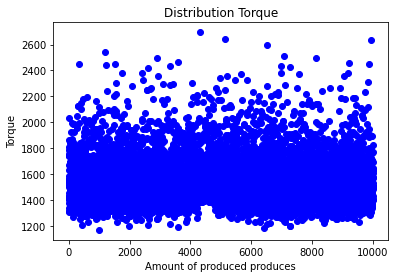

In [396]:
plt.scatter(df[df.Target == 0].index, df[df.Target == 0]['Rotational speed rpm'], color='b')
plt.title('Distribution Torque')
plt.xlabel('Amount of produced produces')
plt.ylabel('Torque')
plt.show()

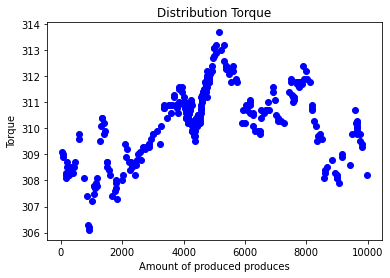

In [397]:
plt.scatter(df[df.Target == 1].index, df[df.Target == 1]['Process temperature K'], color='b')
plt.title('Distribution Torque')
plt.xlabel('Amount of produced produces')
plt.ylabel('Torque')
plt.show()

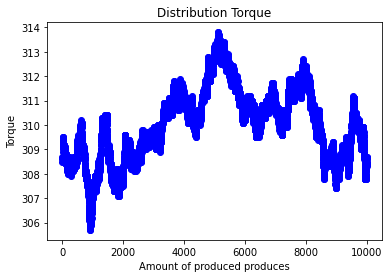

In [398]:
plt.scatter(df[df.Target == 0].index, df[df.Target == 0]['Process temperature K'], color='b')
plt.title('Distribution Torque')
plt.xlabel('Amount of produced produces')
plt.ylabel('Torque')
plt.show()

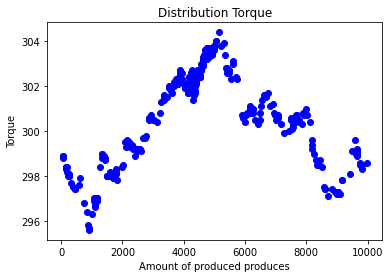

In [400]:
plt.scatter(df[df.Target == 1].index, df[df.Target == 1]['Air temperature K'], color='b')
plt.title('Distribution Torque')
plt.xlabel('Amount of produced produces')
plt.ylabel('Torque')
plt.show()

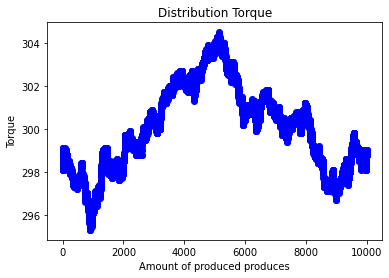

In [401]:
plt.scatter(df[df.Target == 0].index, df[df.Target == 0]['Air temperature K'], color='b')
plt.title('Distribution Torque')
plt.xlabel('Amount of produced produces')
plt.ylabel('Torque')
plt.show()

Due to the distribution, we will insert a binary variable to indicate if Torque is above 45 and simultaneously tool wear above 175.

In [386]:
df['tool_wear_torque_high'] = 0

In [387]:
df.loc[((df['Tool wear min'] > 199)&(df['Rotational speed rpm'] > 140)), 'tool_wear_torque_high'] = 1

We will also have a look which values were predicted wrongly.

In [374]:
df_comparison = pd.concat([data_val.reset_index(),target_val.reset_index(drop=True), pd.Series(prediction)], axis=1)

In [375]:
df_comparison

,index,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,tool_wear_torque_high,Type_H,Type_L,Type_M,Target,0
0,1267,-0.954816,-0.273958,0.055368,-0.129306,-1.007403,0,0.0,0.0,1.0,0,0
1,5085,1.999787,2.026827,-0.904749,1.599876,-0.725095,0,0.0,0.0,1.0,0,0
2,440,-1.305362,-1.018330,-0.837764,-0.079330,-0.834881,0,0.0,1.0,0.0,0,0
3,3445,0.797915,0.402743,0.334472,-0.389183,1.580419,2,0.0,0.0,1.0,0,0
4,1693,-1.004894,-1.695032,0.803366,-1.218791,-1.274027,0,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1595,7388,-0.103489,0.402743,0.864769,-0.868956,0.215931,0,0.0,0.0,1.0,0,0
1596,7443,0.046745,1.079445,0.278651,-0.209268,-1.101505,0,1.0,0.0,0.0,0,0
1597,8008,0.397291,1.282455,-0.698212,0.110581,1.000120,0,0.0,1.0,0.0,0,0
1598,8365,-0.604270,-0.138618,0.066532,-0.339207,-1.446548,0,0.0,0.0,1.0,0,0


In [377]:
index_list = df_comparison[(df_comparison.Target!=df_comparison[0])]['index'].to_list()

In [378]:
df[df.index.isin(index_list)]

,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,tool_wear_torque_high
1162,L,296.9,307.8,1400,57.1,202,1,2
1509,L,298.0,308.5,1429,37.7,220,1,2
1756,M,298.1,307.4,1363,60.1,187,0,0
2332,L,299.2,308.5,1378,50.4,220,1,2
3461,H,301.6,310.4,1330,49.5,30,0,0
4002,L,302.1,311.2,1454,59.2,153,1,0
4191,L,302.4,311.0,1317,59.4,179,0,0
4233,M,302.2,310.9,1302,53.4,58,0,0
4816,L,303.4,312.0,1521,35.9,215,1,2
5617,L,303.1,312.4,1404,61.5,127,1,0


In [388]:
# encode type as last remaining categorical feature
categorical_features = ['Type']
encoder = OneHotEncoder()
#create encoded dataframe
encoded = pd.DataFrame(encoder.fit_transform(df[categorical_features]).toarray(), columns=encoder.get_feature_names(categorical_features))
df_ohe = df.drop(columns=categorical_features).join(encoded)
df_ohe.head(10)

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Target,tool_wear_torque_high,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0.0,0.0,1.0
1,298.2,308.7,1408,46.3,3,0,0,0.0,1.0,0.0
2,298.1,308.5,1498,49.4,5,0,0,0.0,1.0,0.0
3,298.2,308.6,1433,39.5,7,0,0,0.0,1.0,0.0
4,298.2,308.7,1408,40.0,9,0,0,0.0,1.0,0.0
5,298.1,308.6,1425,41.9,11,0,0,0.0,0.0,1.0
6,298.1,308.6,1558,42.4,14,0,0,0.0,1.0,0.0
7,298.1,308.6,1527,40.2,16,0,0,0.0,1.0,0.0
8,298.3,308.7,1667,28.6,18,0,0,0.0,0.0,1.0
9,298.5,309.0,1741,28.0,21,0,0,0.0,0.0,1.0


In [389]:
# first split up in train+val and test
data_train_val, data_test, target_train_val, target_test = train_test_split(df_ohe.drop(columns=['Target']), df_preprocessed['Target'], test_size=0.2, random_state=42, stratify=df_preprocessed['Target'])

In [390]:
#  split up train+val in train and val
data_train, data_val, target_train, target_val = train_test_split(data_train_val, target_train_val, test_size=0.2, random_state=42, stratify=target_train_val)

In [391]:
# define standard scaler
scaler = StandardScaler()
# features to scale
numerical_features = ['Process temperature K','Torque Nm','Tool wear min', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm' ]
# transform data
data_train[numerical_features] = scaler.fit_transform(data_train[numerical_features])
data_val[numerical_features] = scaler.transform(data_val[numerical_features])
data_test[numerical_features] = scaler.transform(data_test[numerical_features])

In [392]:
xgb = XGBClassifier()
cross_val=cross_val_score(xgb, data_train, target_train, cv=5, scoring='f1_macro')
xgb.fit(data_train, target_train)
prediction = xgb.predict(data_val)
f1= f1_score(target_val,prediction, average = 'macro') 
precision = precision_score(target_val,prediction, average = 'macro')
recall = recall_score(target_val,prediction, average = 'macro')
print("CV-average F1-score: %.4f" % cross_val.mean())
print("The F1-Score micro on the validation set: {:.4f}".format(f1))
print("The Precision on the validation set: {:.4f}".format(precision))
print("The Recall on the validation set: {:.4f}".format(recall))
print('Confusion Matrix : \n' + str(confusion_matrix(target_val,prediction)))

C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[19:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of labe

[19:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:23:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Nikla\anaconda3\envs\Industrial-Applications-of-Artificial-Intelligence\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV-average F1-score: 0.8742
The F1-Score micro on the validation set: 0.8644
The Precision on the validation set: 0.9207
The Recall on the validation set: 0.8221
Confusion Matrix : 
[[1540    6]
 [  19   35]]


# VI. Hyperparameter tuning

# VII. Discussion

## VIII. Outlook